In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io as sio
from pyitlib import discrete_random_variable as drv

from tabulate import tabulate

from graphviz import Source

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

## Loading Data

In [2]:
data = sio.loadmat('covtype_reduced.mat')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train'][0]
y_test = data['y_test'][0]

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

data = sio.loadmat('covtype_reduced.mat')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train'].T
y_test = data['y_test'].T

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(468, 54) (116202, 54) (468,) (116202,)
(468, 54) (116202, 54) (468, 1) (116202, 1)


## computing Entropy and conditionalEntropy

In [3]:
def entropy(y):
    if len(y) == 0:
        return 0
    unique, count = np.unique(y, return_counts=True, axis=0)
    individualProbabilities = count/len(y)
    entropy = -np.sum(individualProbabilities*np.log2(individualProbabilities))
    return entropy


#Additional Helper function
def jointEntropy(y,x):
    yx = np.c_[y,x]    
    return entropy(yx)

def cond_entropy(y,yhat):
    return jointEntropy(y,yhat) - entropy(yhat)

random_sequences = sio.loadmat('random_sequences.mat')

s1 = random_sequences['s1'][0]
s2 = random_sequences['s2'][0]

print ('entropy = ', entropy(s1))
print ('conditional entropy = ', cond_entropy(s1,s2))

print("\n====Verification with in-built functions")
print("verification entropy = :",drv.entropy(s1))
print("verification conditional entropy = :",drv.entropy_conditional(s1,s2))

entropy =  3.3141823231610834
conditional entropy =  3.3029598816135173

====Verification with in-built functions
verification entropy = : 3.3141823231610834
verification conditional entropy = : 3.3029598816135173


## Tree Class and its functions

In [19]:
class Tree:
    def __init__(self, 
                 max_depth = 10,
                 minimum_gain = 1e-7, 
                 min_samples_split = 2):
        self.max_depth = max_depth        
        self.minimum_gain = minimum_gain
        self.min_samples_split = min_samples_split

    def fit(self, X, y):        
        self.numberOfClasses = np.unique(y).shape[0]        
        self.feature_importance = np.zeros(X.shape[1])
        # 1st call to create the Decision Tree
        self.tree = getDecisionTree(X, y, 
                                    self.max_depth,
                                    self.minimum_gain,
                                    self.min_samples_split, 
                                    self.numberOfClasses,
                                    self.feature_importance, 
                                    X.shape[0])
        self.feature_importance /= np.sum(self.feature_importance)        
        return self

    def predict(self,X):
        """
        Traverse each row and predict the relevant class.
        """
        predictions =[]
        for i in range(X.shape[0]):
            temp = self.classifyExample(X[i, :], self.tree)        
            predictions.append(temp)
        return predictions

    def classifyExample(self,example, tree):
        """
        classification is done recurssively until you reach the leaf node
        """
        
        # base case
        if tree['is_leaf']:
            return np.argmax(tree['prob'])
        
        # recurssion
        else:        
            featureName, value = tree['split_col'], tree['threshold']
            
            splitColumn = tree['split_col']
            featureType = FEATURE_TYPES[splitColumn]
            
            # Differentiating between continuous and categorical values
            
            if featureType == "continuous":        
                if example[featureName] <= value:
                    return self.classifyExample(example, tree['left'])
                else:
                    return self.classifyExample(example, tree['right'])
            else:               
                if example[featureName] == value:
                    return self.classifyExample(example, tree['left'])
                else:
                    return self.classifyExample(example, tree['right'])  

    def printTree(self):
        """
        Helper function to print the tree for debugging.
        """        
        print ('printing tree...')
        def printNode(parent, tree, childType):
            if not tree:
                return
            if parent is  None:
                print(', ROOT', )
                # Differentiating between continuous and categorical values
                if tree['featureType'] == "continuous":
                    print(', ROOT, Condition: ' +str(tree['colName'])+ '<= '+ str(tree['threshold']))                
                else:                
                    print(', ROOT, Condition: ' +str(tree['colName'])+ '== '+ str(tree['threshold']))
            
            # Differentiating between Leaf Node and Non-Leaf Node
            if tree['is_leaf']: 
                print(', LEAF, ', 'Total Samples '+str(sum(tree['counts'])) + ' , Distribution' + str(tree['counts']))
            else:
                # Differentiating between continuous and categorical values
                if tree['featureType'] == "continuous":
                    if childType == "left":
                        print(', NONLEAF, Condition: ' +str(tree['colName'])+ '<= '+ str(tree['threshold']))
                    else:
                        print(', NONLEAF, Condition: ' +str(tree['colName'])+ '> '+ str(tree['threshold']))
                else:
                    if childType == "left":
                        print(', NONLEAF, Condition: ' +str(tree['colName'])+ '== '+ str(tree['threshold']))
                    else:
                        print(', NONLEAF, Condition: ' +str(tree['colName'])+ '!= '+ str(tree['threshold']))

                printNode(tree, tree['left'], "left")
                printNode(tree, tree['right'], "right")

        printNode(None, tree.tree,"")                           

## Decision Tree helper functions

In [20]:
def getDecisionTree(X, y, max_depth,
                          minimum_gain,
                          min_samples_split, numberOfClasses,
                          feature_importance, n_row):
    """
    Recusively constructs a Decision tree
    1) Determine if we can split the tree (or) is it a leaf node.
    2) If we can split:
        i) Find best split
        ii) Recusrivel call Decision tree on both the splits (in our case, it is binary decision tree)
    3) If we cannot split, i.e. it is a Leaf Node
        i) We store the distribution of the data('label') at the leaf node and use this information in our prediction.
    """
    
    if max_depth>0 and X.shape[0] > min_samples_split :
        column, value, informationGain = findBestSplit(X, y)
        if informationGain > minimum_gain:
            feature_importance[column] += (X.shape[0] / n_row) * informationGain
        
        # computing left and right child
        left_X, right_X, left_y, right_y = splitData(X, y, column, value)
        left_child = getDecisionTree(left_X, left_y, 
                                     max_depth - 1,
                                     minimum_gain,
                                     min_samples_split, 
                                     numberOfClasses,
                                     feature_importance, 
                                     n_row)
        right_child = getDecisionTree(right_X, right_y, 
                                      max_depth - 1,
                                      minimum_gain, 
                                      min_samples_split, 
                                      numberOfClasses,
                                      feature_importance,
                                      n_row)
        nonLeafNode = {
        'is_leaf': False,
        'split_col': column,
        'colName': COLUMN_HEADERS[column],
        'featureType': FEATURE_TYPES[column],
        'threshold': value,            
        'left': left_child,
        'right': right_child
        }
        return nonLeafNode
    elif X.shape[0] >0 :        
        counts = np.bincount(y, minlength = numberOfClasses)
        prob = counts / y.shape[0]        
        leafNode = {'is_leaf': True, 'prob': prob,'counts':counts}
        return leafNode


def findBestSplit(X, y):
    """
    We try to determine which is the best split for the data based on the Information gain.
    1) We find all the unique values for every column, be it continuous (or) categorical
    2) We split the data at every unique value for every column and find the informationGain at that
       value for that column.
    3) we pick the column and corresponding split value where we get the maximum information gain.
    """
    bestSplitColumn, bestSplitValue, maxInformationGain = None, None, None
    existingEntropy = entropy(y)
    totalFeatures   = X.shape[1]
    for column in range(totalFeatures):
        splitValues = np.unique(X[:, column])
        for value in splitValues:            
            splits = splitData(X, y, column, value, return_X = False)
            informationGain = existingEntropy - computeEntropyAfterSplit(y, splits)
            if maxInformationGain is None or informationGain > maxInformationGain:
                bestSplitColumn, bestSplitValue, maxInformationGain = column, value, informationGain
    return bestSplitColumn, bestSplitValue, maxInformationGain

def splitData(X, y, splitColumn, splitValue, return_X=True):
    """
    1) Takes the input data (X,Y).
    2) Uses the splitColumn and splitValue to split the data into 2 halves:
        i) In case of continuous data
            a) We split them as rowsBelowThreshold and rowsAboveThreshold
        ii) In case of categorical data (Here we have binary data)
            a) We split them as rowsWhereValueIsZero and rowsWhereValueIsOne
    """
    
    type_of_feature = FEATURE_TYPES[splitColumn]
    splitColumnValues = X[:, splitColumn]
    if type_of_feature == "continuous":        
        rowsBelowThreshold =  splitColumnValues <= splitValue
        rowsAboveThreshold =  splitColumnValues >  splitValue

    else:#categorical
        rowsBelowThreshold =  splitColumnValues == splitValue
        rowsAboveThreshold =  splitColumnValues !=  splitValue

    XBelowThresshold   = X[rowsBelowThreshold]
    YBelowThreshold    = y[rowsBelowThreshold]

    XAboveThresshold   = X[rowsAboveThreshold]
    YAboveThreshold    = y[rowsAboveThreshold]

    if not return_X:
        return YBelowThreshold, YAboveThreshold    
    return XBelowThresshold,XAboveThresshold,YBelowThreshold,YAboveThreshold


def entropy(y):
    """
    Computes entropy for the given column
    """
    values, counts = np.unique(y, return_counts = True)
    p = counts / y.shape[0]
    entropy = -np.sum(p * np.log2(p))
    return entropy


def computeEntropyAfterSplit(y, splits):
    """
    Computes Entropy of the data after splitting into 2 halves.
    This information is used to compute the informationGain.
    """
    
    splits_entropy = 0
    for split in splits:
        splits_entropy += (split.shape[0] / y.shape[0]) * entropy(split)
    return splits_entropy


def getLeafNodeInfo(tree):
    """
    Gives information about all the leaf nodes present in the tree.
    Leaf Nodes Information include the following:
    1) Total samples in the leaf node
    2) Distribution of the samples in the leaf node.
    """
    
    global output
    output = []
    def getDetailedInfo(parent, tree, childType):
        if not tree:
            return
        if tree['is_leaf']: 
            a = 'LEAF, ', 'Total Samples '+ "{0:0=3d}".format(sum(tree['counts'])) + ' , Distribution ' + str(tree['counts'])            
            output.append(a)        
        else:
            getDetailedInfo(tree, tree['left'], "left")
            getDetailedInfo(tree, tree['right'], "right")
    
    getDetailedInfo(None, tree,"")
    for index,details in enumerate(output):
        print("Leaf Node "+"{0:0=2d}".format(index+1) + " "+str(details[1]))
    return

def determineTypeOfFeature(data):
    """
    Determing whether a feature is categorical or continuous.
    Here, we are using our existing knowledge of the dataset, i.e. 
    first 10 columns are continuous and remaining are categorical values.
    """
    
    totalColumns = data.shape[1]
    output = []
    for columnIndex in range(totalColumns):
        if columnIndex<=9:
            output.append('continuous')
        else:
            output.append('categorical')
    return output

In [21]:
data = sio.loadmat('covtype_reduced.mat')
X_train = data['X_train'].astype(float)
X_test = data['X_test'].astype(float)
y_train = data['y_train'][0].astype(int)
y_test = data['y_test'][0].astype(float)

global COLUMN_HEADERS, FEATURE_TYPES
COLUMN_HEADERS = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'label']
COLUMN_HEADERS = COLUMN_HEADERS
FEATURE_TYPES = determineTypeOfFeature(X_train)

results = []
for depth in range(1,6):
    tree = Tree(max_depth=depth, min_samples_split=2)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_train)
    y_pred2 = tree.predict(X_test)
    results.append((2**depth,
                    "{0:.2f}".format(100*accuracy_score(y_train, y_pred))+' %',
                    "{0:.2f}".format(100*(1-accuracy_score(y_train, y_pred)))+' %',
                    "{0:.2f}".format(100*accuracy_score(y_test, y_pred2))+' %',
                    "{0:.2f}".format(100*(1-accuracy_score(y_test, y_pred2)))+' %'))

columns = ['No of Splits','Train Accuracy','Train Error', 'Test Accuracy', 'Test Error']
df = pd.DataFrame(results, columns=columns)
df.reset_index()
print(tabulate(df, headers='keys', tablefmt='psql')) 

+----+----------------+------------------+---------------+-----------------+--------------+
|    |   No of Splits | Train Accuracy   | Train Error   | Test Accuracy   | Test Error   |
|----+----------------+------------------+---------------+-----------------+--------------|
|  0 |              2 | 49.79 %          | 50.21 %       | 50.40 %         | 49.60 %      |
|  1 |              4 | 62.82 %          | 37.18 %       | 73.32 %         | 26.68 %      |
|  2 |              8 | 63.68 %          | 36.32 %       | 70.29 %         | 29.71 %      |
|  3 |             16 | 67.31 %          | 32.69 %       | 73.01 %         | 26.99 %      |
|  4 |             32 | 72.65 %          | 27.35 %       | 63.50 %         | 36.50 %      |
+----+----------------+------------------+---------------+-----------------+--------------+


## Leaf Nodes Info

In [22]:
getLeafNodeInfo(tree.tree)

Leaf Node 01 Total Samples 001 , Distribution [0 0 0 0 1 0 0]
Leaf Node 02 Total Samples 003 , Distribution [0 0 2 1 0 0 0]
Leaf Node 03 Total Samples 003 , Distribution [0 0 0 3 0 0 0]
Leaf Node 04 Total Samples 001 , Distribution [0 0 1 0 0 0 0]
Leaf Node 05 Total Samples 004 , Distribution [0 0 0 4 0 0 0]
Leaf Node 06 Total Samples 006 , Distribution [0 0 0 1 0 0 5]
Leaf Node 07 Total Samples 019 , Distribution [ 0  0  0 15  0  0  4]
Leaf Node 08 Total Samples 009 , Distribution [0 0 6 0 0 0 3]
Leaf Node 09 Total Samples 004 , Distribution [0 0 0 4 0 0 0]
Leaf Node 10 Total Samples 026 , Distribution [ 0  4 22  0  0  0  0]
Leaf Node 11 Total Samples 009 , Distribution [0 1 4 0 0 0 4]
Leaf Node 12 Total Samples 001 , Distribution [0 0 1 0 0 0 0]
Leaf Node 13 Total Samples 009 , Distribution [0 0 9 0 0 0 0]
Leaf Node 14 Total Samples 007 , Distribution [0 2 4 0 0 1 0]
Leaf Node 15 Total Samples 014 , Distribution [0 0 4 6 0 4 0]
Leaf Node 16 Total Samples 003 , Distribution [0 3 0 0 0

## Printing a sample tree for visualisation

In [23]:
tree = Tree(max_depth=2, min_samples_split=2)
tree.fit(X_train, y_train)
tree.printTree()

printing tree...
, ROOT
, ROOT, Condition: Elevation<= 2843.0
, NONLEAF, Condition: Elevation> 2843.0
, NONLEAF, Condition: Elevation<= 2524.0
, LEAF,  Total Samples 37 , Distribution[ 0  0  3 24  1  0  9]
, LEAF,  Total Samples 79 , Distribution[ 0  7 50 10  0  5  7]
, NONLEAF, Condition: Elevation> 3170.0
, LEAF,  Total Samples 220 , Distribution[  0  89 129   0   0   2   0]
, LEAF,  Total Samples 132 , Distribution[ 0 91 22  0  0  0  0 19]


## Algorithm

In [25]:
from graphviz import Digraph

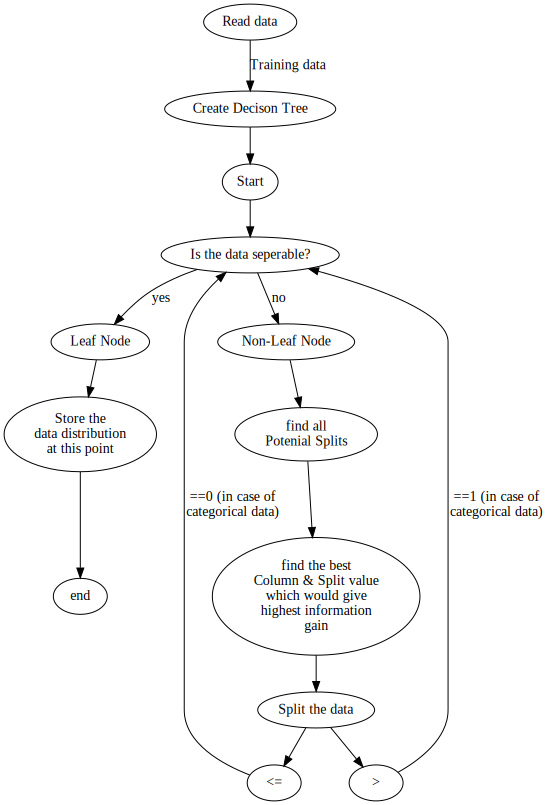

In [67]:
g = Digraph('G')

g.edge('Read data', 'Create Decison Tree', label='Training data')
g.edge('Create Decison Tree','Start')
g.edge('Start', 'Is the data seperable?')
g.edge('Is the data seperable?', 'Leaf Node', label='yes')
g.edge('Leaf Node', 'Store the \ndata distribution\n at this point')
g.edge('Store the \ndata distribution\n at this point','end')
g.edge('Is the data seperable?', 'Non-Leaf Node', label='no')
g.edge('Non-Leaf Node', 'find all \n Potenial Splits')
g.edge('find all \n Potenial Splits', 'find the best \n Column & Split value \n which would give \n highest information \n gain')
g.edge('find the best \n Column & Split value \n which would give \n highest information \n gain', 'Split the data')
g.edge('Split the data', '<=')
g.edge('Split the data', '>')
g.edge('<=','Is the data seperable?',label='==0 (in case of \n categorical data)')
g.edge('>','Is the data seperable?' ,label='==1 (in case of \n categorical data)')

g

## Verification with in-built function

+----+---------+------------------+---------------+-----------------+--------------+
|    |   Depth | Train Accuracy   | Train Error   | Test Accuracy   | Test Error   |
|----+---------+------------------+---------------+-----------------+--------------|
|  0 |       5 | 72.65 %          | 27.35 %       | 64.95 %         | 35.05 %      |
+----+---------+------------------+---------------+-----------------+--------------+


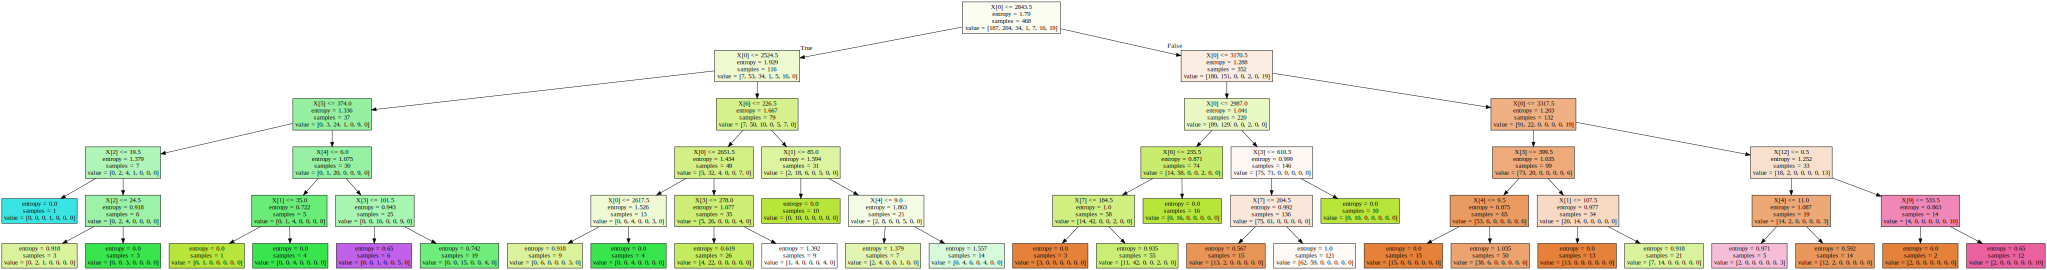

In [24]:
clf = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 2, max_depth = 5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
y_pred2 = clf.predict(X_test)

results = []
results.append((depth,
                    "{0:.2f}".format(100*accuracy_score(y_train, y_pred))+' %',
                    "{0:.2f}".format(100*(1-accuracy_score(y_train, y_pred)))+' %',
                    "{0:.2f}".format(100*accuracy_score(y_test, y_pred2))+' %',
                    "{0:.2f}".format(100*(1-accuracy_score(y_test, y_pred2)))+' %'))

columns = ['Depth','Train Accuracy','Train Error', 'Test Accuracy', 'Test Error']
df = pd.DataFrame(results, columns=columns)
df.reset_index()
print(tabulate(df, headers='keys', tablefmt='psql')) 

export_graphviz(clf, filled = True,
                 out_file = 'tree.dot')

os.system('dot -Tpng tree.dot -o tree.jpeg')
with open('tree.dot') as f:
    dot_graph = f.read()

Source(dot_graph)

## Resources

1) https://piazza.com/class/kdhx0iapnk06la?cid=347

2) https://www.youtube.com/watch?v=y6DmpG_PtN0&list=PLPOTBrypY74xS3WD0G_uzqPjCQfU6IRK-&index=1&ab_channel=SebastianMantey